In [2]:
from growth import model, integrate, viz
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd

consts=model.load_constants()

## Exploration of Phage infection dynamics with the Flux Parity model (FPM)

### Rationale
Previous studies of bacteriophage infections have been focused on phage biology and phage infection steps/mechanisms. Here, we apply the "flux parity" protein allocation model to a bacteriophage-infected *E. coli* cell to assess the dynamics of viral proteome accumulation inside the bacteria.

### Assumptions
For the plots in this notebook, we assumed the following:
- Initial biomass is set to $10^9$ amino acids, roughly the biomass of a single *E. coli* cell at birth.
- Initial conditions are steady-state growth in rich nutrient conditions ($\nu_{max} = 20$).
- At $t=0$, $\phi_{phage}$ is instantly "turned on". $\phi_{phage}$ represents the fraction of the proteome allocation towards viral protein expression.
- The mass of one phage is assumed to be $\approx 30*10^6$ Daltons, which is also the molecular mass of the phage genome.
- Phage assembly is assumed to be growth-limited, thus making viral protein translation dynamics the relevant dynamic for phage infection timescales.

### Implementation
After finding the steady-state proteome allocation of the bacteria for the given nutrient conditions, we instantly add a proteome sector ($\phi_{Ph}$) at $t=0\ hr$ and rescale all other sectors proportionally to their previous optimal allocation such that $\phi_{tot}=\phi_{O}+\phi_{Rb}+\phi_{Mb}+\phi_{Ph}=1$. We then integrate the model ODE equations to numerically solve for $M_{tot}(t)$, $M_O(t)$, $M_{Rb}(t)$, $M_{Mb}(t)$, $M_{Ph}(t)$, $c_{pc}(t)$, and $c_{nt}(t)$ for $t=0-30\ hrs$ and $dt=1 \times 10^{-4}\ hr$.

### Setup and ODE integration

In [3]:
# Load constants and parameters
phi_O=consts['phi_O']
gamma_max=consts['gamma_max']
Kd_cpc=consts['Kd_cpc']
Kd_cnt=consts['Kd_cnt']
Y=consts['Y']
nu_max=20
consts['nu_max']=nu_max
f_a=1
m_Rb=consts['m_Rb']
m_phage=30*10**6/110 # Dalton mass of viral proteome / (Dalton mass of 1 a.a.)
phi_Ph_vals=np.linspace(0,1,11) # Generate Phi phage values

In [4]:
# Set inital steady state conditions
phi_O_ss=consts['phi_O']
phi_Rb_ss=model.phiRb_optimal_allocation(gamma_max,nu_max,Kd_cpc,phi_O_ss)
phi_Mb_ss=1-phi_O_ss-phi_Rb_ss
c_pc=model.steady_state_precursors(gamma_max, phi_Rb_ss, nu_max, Kd_cpc, phi_O_ss)
M0=1e9
init_params = [M0,M0*phi_O_ss,M0*phi_Rb_ss,M0*phi_Mb_ss,0,c_pc,1]

# Integrate ODEs for each phi_Ph value
out_vars=['M','M_O','M_Rb','M_Mb','M_Ph','c_pc','c_nt'] # variable names for the variables integrated over time
out=[]
for phi_Ph in phi_Ph_vals:

    # Set new allocations proportionally to initial SS optimal allocation
    phi_O = phi_O_ss*(1-phi_Ph)
    phi_Rb = phi_Rb_ss*(1-phi_Ph)
    phi_Mb = phi_Mb_ss*(1-phi_Ph)

    # Integration parameters
    max_time = 30
    dt=0.0001
    

    # Perform integration and store results in out
    time = np.arange(0, max_time, dt)
    out += [scipy.integrate.odeint(model.self_replicator_lytic_phage, 
                    init_params, 
                    time,args=(gamma_max,nu_max,Y,phi_Rb,phi_Mb,phi_Ph,Kd_cpc,Kd_cnt))]

In [39]:
# Create dataframe to store results of ODE integration
df=pd.DataFrame()
for i in range(len(phi_Ph_vals)):
    _df=pd.DataFrame()
    _df['time']=np.linspace(0,max_time,int(max_time/dt))
    for j in range(len(out_vars)):
        _df[out_vars[j]]=out[i][:,j]
    _df['phi_Ph_val']=phi_Ph_vals[i]
    df=pd.concat([df,_df])

# Print dataframe column names
df.columns

Index(['time', 'M', 'M_O', 'M_Rb', 'M_Mb', 'M_Ph', 'c_pc', 'c_nt',
       'phi_Ph_val'],
      dtype='object')

### Results and Interpretations

Let's first take a look at how different phage allocations affect both total biomass and phage biomass increase over time.

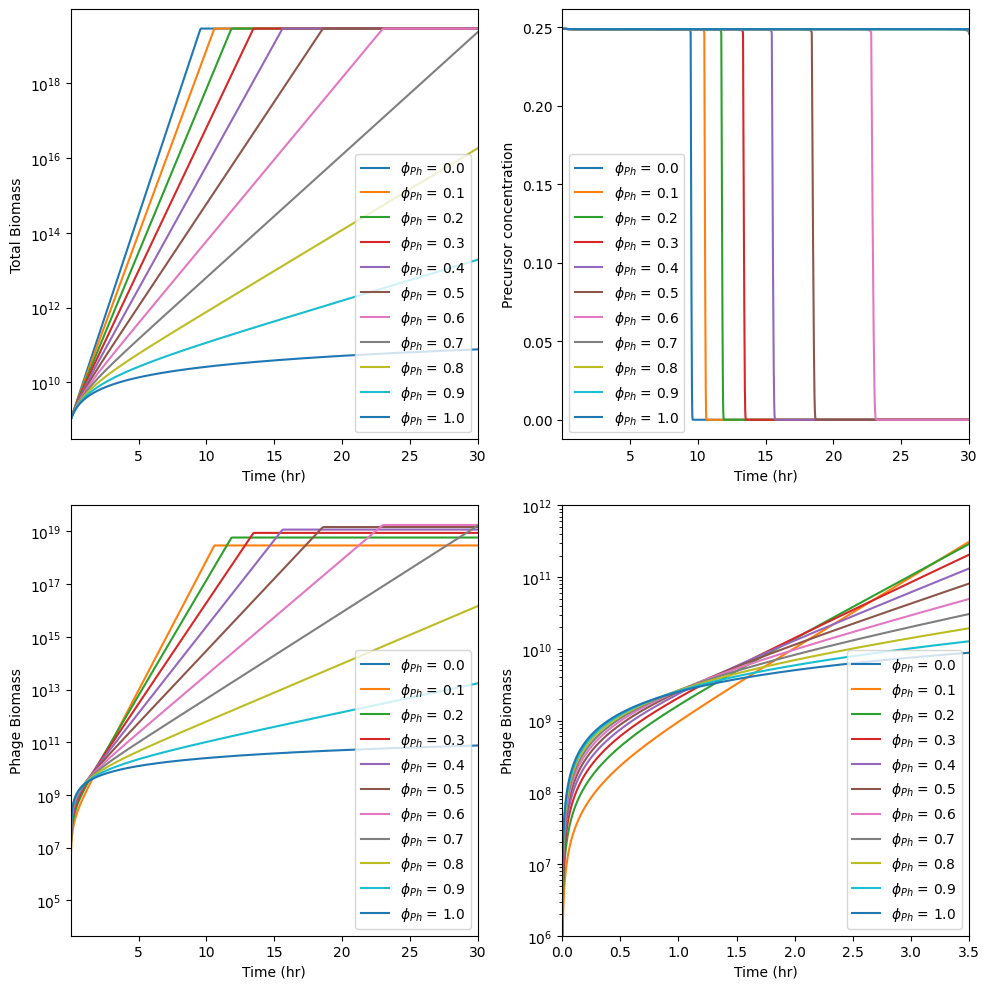

In [195]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
for phi in phi_Ph_vals:
    x_val=df.loc[df.phi_Ph_val==phi].time
    y_val=df.loc[df.phi_Ph_val==phi].M
    plt.plot(x_val,y_val,label='$\phi_{Ph}$ = %.1f'%(phi))
plt.legend()
plt.xlabel('Time (hr)')
plt.ylabel('Total Biomass')
plt.yscale('log')
plt.xlim([1e-2,3e1]);

plt.subplot(2,2,2)
for phi in phi_Ph_vals:
    x_val=df.loc[df.phi_Ph_val==phi].time
    y_val=df.loc[df.phi_Ph_val==phi].c_pc
    plt.plot(x_val,y_val,label='$\phi_{Ph}$ = %.1f'%(phi))
plt.legend()
plt.xlabel('Time (hr)')
plt.ylabel('Precursor concentration')
plt.xlim([1e-2,3e1]);

plt.subplot(2,2,3)
for phi in phi_Ph_vals:
    x_val=df.loc[df.phi_Ph_val==phi].time
    y_val=df.loc[df.phi_Ph_val==phi].M_Ph
    plt.plot(x_val,y_val,label='$\phi_{Ph}$ = %.1f'%(phi))
plt.legend()
plt.xlabel('Time (hr)')
plt.ylabel('Phage Biomass')
plt.yscale('log')
plt.xlim([1e-2,3e1]);

plt.subplot(2,2,4)
for phi in phi_Ph_vals:
    x_val=df.loc[df.phi_Ph_val==phi].time
    y_val=df.loc[df.phi_Ph_val==phi].M_Ph
    plt.plot(x_val,y_val,label='$\phi_{Ph}$ = %.1f'%(phi))
plt.legend()
plt.xlabel('Time (hr)')
plt.ylabel('Phage Biomass')
plt.yscale('log')
plt.ylim([1e6,1e12])
plt.xlim([0,3.5]);

plt.tight_layout()


In the first subplot above, we first verify the accumulation of total biomass over time for each phage proteome allocation. As expected, all $\phi_{Ph} < 1$ values yield a new steady state with gradually increasing growth rates as $\phi_{Ph}$ decreases. It is noteworthy that $\phi_{Ph} = 1$ never reaches a new steady state. For that condition, translation of phage protein is linear in time as no new ribosomes or metabolic proteins are being expressed, a requirement for exponential growth of phage proteins as observed in sub-total phage allocations. Additionally, for total phage allocation, we would anticipate phage proteome translation to eventually come to a halt once ribosomes and metabolic proteins are diluted out. However, this would take much longer than the length of the expreriment simulated and is thus likely irrelevant to phage infection dynamics.

The second subplot is a control to confirm that growth stops simultaneously with precursor concentration.

The third subplot shows the accumulation of phage biomass over time. This plot is similar qualitatively to the total biomass growth with two quantiative differences:
- The final phage biomass is different for each allocation while the final total biomass is always the same (we expect $M_{Ph\ final} \approx \phi_{Ph}*M_{tot\ final}$ )
- The initial dynamics are different: higher $\phi_{Ph}$ values accumulate phage biomass faster initially but reach a slower steady state.

The fourth subplot displays these two different dynamics for each $\phi_{Ph}$ value.

We can also plot the concentration of phage proteins in the cell over time ($M_{Ph}/M$):

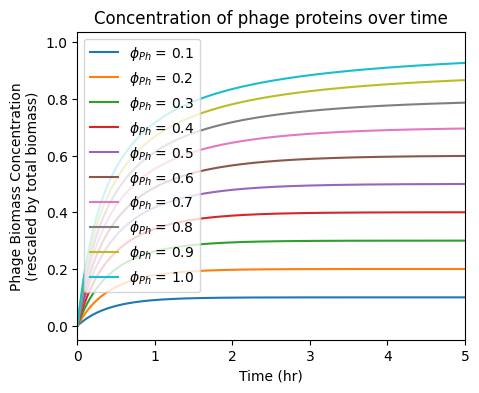

In [193]:
plt.figure(figsize=(5,4))

nonzero_phi_Ph_vals = np.delete(df.phi_Ph_val.unique(),0)
for phi in nonzero_phi_Ph_vals:
    x_val=df.loc[df.phi_Ph_val==phi].time
    y_val=df.loc[df.phi_Ph_val==phi].M_Ph/df.loc[df.phi_Ph_val==phi].M
    plt.plot(x_val,y_val,label='$\phi_{Ph}$ = %.1f'%(phi))

plt.legend()
plt.xlabel('Time (hr)')
plt.ylabel('Phage Biomass Concentration\n(rescaled by total biomass)')
plt.title('Concentration of phage proteins over time')
plt.xlim([0,5]);

As expected, the concentration of phage proteins in the cell asymptotically reaches the allocation towards phage protein over time. While this is perhaps an obvious results, this result implies that concentration-dependent processes of phage assembly might necessitate a minimum phage allocation to reach completion in a timely manner.m

Now that we have seen how our system evolves with time, we would like to highlight the trade-off between low and high phage allocation strategies using two different metrics: 
- Time to match the phage protein mass for $\phi_{Ph}=1$.
- "Burst size" (number of phages inside the cell) for which a given allocation is optimal. That is, the given "burst size" is reached the fastest by the corresponding phage allocation.

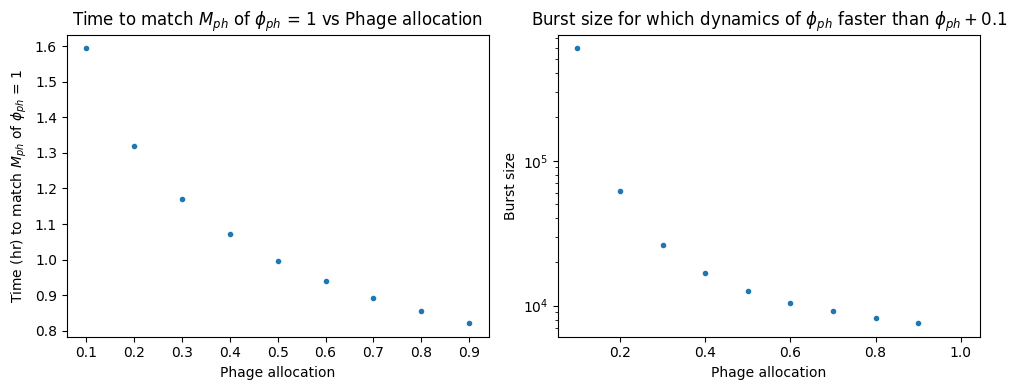

In [94]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)

phi_val = []
time_match = []
nonzero_phi_Ph_vals = np.delete(df.phi_Ph_val.unique(),0)
df_phi_one=df.loc[df.phi_Ph_val==1]

for phi in nonzero_phi_Ph_vals: # loop over phi values
    df_phi_val=df.loc[df.phi_Ph_val==phi] # dataframe for a particular phi value
    for t_ in range(len(df.time.unique())): # loop over time
        if df_phi_one.M_Ph[t_] < df_phi_val.M_Ph[t_]: # Check if phage mass of current phi value bigger than phage mass for phi 1
            phi_val+=[phi]
            time_match+=[df.time.unique()[t_]]
            break

plt.plot(phi_val,time_match,'.',label='nu_max = %.1f'%(phi_Ph_vals[i]))

plt.xlabel('Phage allocation')
plt.ylabel('Time (hr) to match $M_{ph}$ of $\phi_{ph}$ = 1')
plt.title('Time to match $M_{ph}$ of $\phi_{ph}$ = 1 vs Phage allocation')

plt.subplot(1,2,2)
burst_size_match = []
phi_val = []
phi_prev=0
nonzero_phi_Ph_vals_reverse = nonzero_phi_Ph_vals[::-1]
for phi in nonzero_phi_Ph_vals_reverse: # reverse order necessary to find when lower allocation matches with higher allocation
    df_prev_phi=df.loc[df.phi_Ph_val==phi_prev]
    df_current_phi=df.loc[df.phi_Ph_val==phi]
    for t_ in range(len(df.time.unique())):
        if df_current_phi.M_Ph[t_] > df_prev_phi.M_Ph[t_]: # Check if current allocation has surpassed previous allocation in terms of phage biomass
            burst_size_match +=[df_current_phi.M_Ph[t_]//m_phage]
            phi_val+=[phi]
            phi_prev=phi
            break
plt.plot(phi_val,burst_size_match,'.')
plt.xlabel('Phage allocation')
plt.ylabel('Burst size')
plt.title('Burst size for which dynamics of $\phi_{ph}$ faster than $\phi_{ph}+0.1$')
plt.yscale('log')

plt.tight_layout()


The left subplot shows the time for which a given phage allocation matches the proteinaceous mass of a complete phage allocation ($\phi_{Ph}=1$). As expected, this time is shorter for higher phage allocations. This plot showcases that high allocations are significantly different in timescales compared to lower allocations.

The right subplot indicates the "burst size" (number of phages in the cell) for which a given allocation is the fastest strategy compared to any lower allocations. As "burst size" increases, the best allocation strategy is increasingly smaller because a steady state with a faster is reached. It seems that the burst size is asymptotically approaching a threshold value as $\phi_{Ph}$ approaches 1, indicating that maximal phage allocation is the best strategy for any burst size below this value.

Assuming that the objective function of a phage is to produce the most phages possible in the least amount of time, we can also plot the maximum amount of phages that can be produced given a certain amount of time (and the converse, the minimum time it takes to make a particular amount of phage) for any allocation.

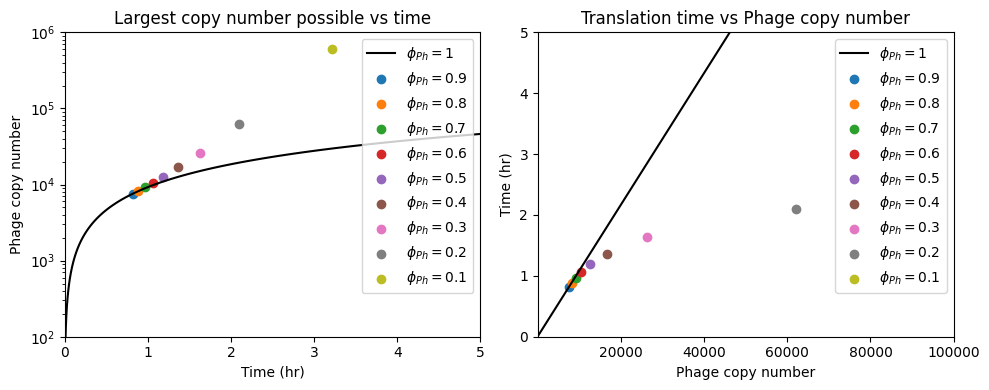

In [192]:
plt.figure(figsize=(10,4))

burst_size_match = []
time_match = []
phi_val = []
phi_prev=1
phi_Ph_vals_reverse=phi_Ph_vals[::-1]
for phi in phi_Ph_vals_reverse:
    df_prev_phi=df.loc[df.phi_Ph_val==phi_prev]
    df_current_phi=df.loc[df.phi_Ph_val==phi]
    for t_ in range(len(df.time.unique())):
        if df_current_phi.M_Ph[t_] > df_prev_phi.M_Ph[t_]: # Check if current allocation has surpassed previous allocation in terms of phage biomass
            burst_size_match +=[df_current_phi.M_Ph[t_]//m_phage]
            time_match +=[df.time.unique()[t_]]
            phi_val +=[phi]
            phi_prev=phi
            break

plt.subplot(1,2,1)
x_val=df.time.unique()
y_val=df.loc[df.phi_Ph_val==1].M_Ph//m_phage
plt.plot(x_val,y_val,color='k',label='$\phi_{Ph} = 1$') # plot curve for phi = 1 strategy
for i in range(len(time_match)):
    plt.scatter(time_match[i],burst_size_match[i],label='$\phi_{Ph} = %.1f$'%(phi_val[i])) # Plot individual points for 

plt.xlabel('Time (hr)')
plt.ylabel('Phage copy number')
plt.title('Largest copy number possible vs time')
plt.yscale('log')
plt.ylim([1e2,1e6])
plt.xlim([0,5])
plt.legend()

plt.subplot(1,2,2)
plt.plot(y_val,x_val,color='k',label='$\phi_{Ph} = 1$') # Reverse x and y axes
for i in range(len(time_match)):
    plt.scatter(burst_size_match[i],time_match[i],label='$\phi_{Ph} = %.1f$'%(phi_val[i]))

plt.ylabel('Time (hr)')
plt.xlabel('Phage copy number')
plt.title('Translation time vs Phage copy number')
plt.xlim([1e2,1e5])
plt.ylim([0,5])
plt.legend()

plt.tight_layout()

In the left subplot, the maximum phage copy number achievable for a given "infection time" is shown in black for $\phi_{Ph}=1$. This allocation strategy is the best for short infection times. However, at ~ 0.8 hours, lower allocation strategies will become more optimal to produce the biggest amount of phage possible. This is because $\phi_{Ph}=1$ leads to a linear increase in phage biomass as opposed to an exponential increase for the other allocation strategies.

The right subplot shows the converse relation. 

### Future things to do

- Plot with different nutrient conditions (heatmaps)
- Try to analytically express the M_Ph vs time plots as an linear growth ($\phi_{Ph}=1$) added to an exponential growth (dictated by $1-\phi_{Ph}$)